# Trading Commodity Futures based on 5y5y forward inflation

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
import sys
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\CommodityForwardInflation\root\src")
from SignalReturn import SignalReturn

In [3]:
df_raw = SignalReturn().get_raw_rtn()
df_is  = SignalReturn().get_is_rtn()
df_oos = SignalReturn().get_oos_rtn()

def get_rtn(df_is: pd.DataFrame, df_oos: pd.DataFrame) -> pd.DataFrame: 
    
    df_rtn = (pd.concat([
        df_is[["date", "security", "signal_rtn", "inf_ticker"]].assign(group = "in_sample"),
        df_oos[["date", "security", "signal_rtn", "inf_ticker"]].assign(group = "out_sample")]))
    
    return df_rtn

df_rtn = get_rtn(df_is, df_oos)

## Returns Analysis

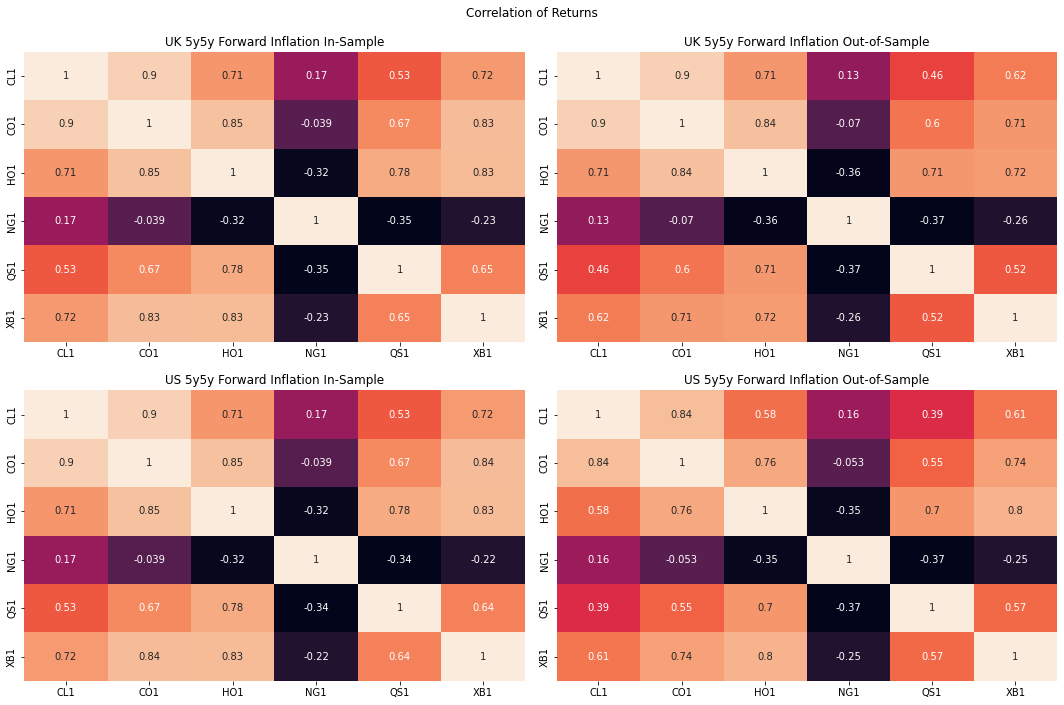

In [4]:
def plot_correlation(df_rtn: pd.DataFrame) -> plt.Figure: 
    
    df_combined = (df_rtn.assign(
        inf_ticker = lambda x: np.where(x.inf_ticker == "FWISBP55", "UK 5y5y Forward Inflation", "US 5y5y Forward Inflation"),
        group      = lambda x: np.where(x.group == "in_sample", "In-Sample", "Out-of-Sample"),
        group_var  = lambda x: x.inf_ticker + " " + x.group))

    group_vars = df_combined.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (15,10))

    for group_var, ax in zip(group_vars, axes.flatten()):

        df_corr = (df_combined.query(
            "group_var == @group_var").
            pivot(index = "date", columns = "security", values = "signal_rtn").
            corr())

        sns.heatmap(
            ax    = ax,
            data  = df_corr,
            cbar  = False,
            annot = True)

        ax.set_title(group_var)
        ax.set_xlabel(""); ax.set_ylabel("")

    fig.suptitle("Correlation of Returns")
    plt.tight_layout(pad = 1.5)
    
plot_correlation(df_rtn)

# Backtested Returns

In [5]:
def plot_rtn(df_raw: pd.DataFrame, title: str) -> plt.Figure: 
    
    inflations = df_raw.inf_ticker.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(inflations), figsize = (20,6))

    title_renamer = {
        "FWISBP55": "UK Forward Inflation",
        "FWISUS55": "US Forward Inflation"}

    for inflation, ax in zip(inflations, axes.flatten()):

        (df_raw.query(
            "inf_ticker == @inflation").
            rename(columns = {"security": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            apply(lambda x: np.cumprod(1 + x) -1).
            plot(
                ax     = ax,
                ylabel = "Cumulative Return (%)",
                title  = title_renamer[inflation]))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Trading Commodity Futures based on the {} of 5y5y Forward Inflation\nWith 10% Volatility Scaling".format(title))
    plt.tight_layout()

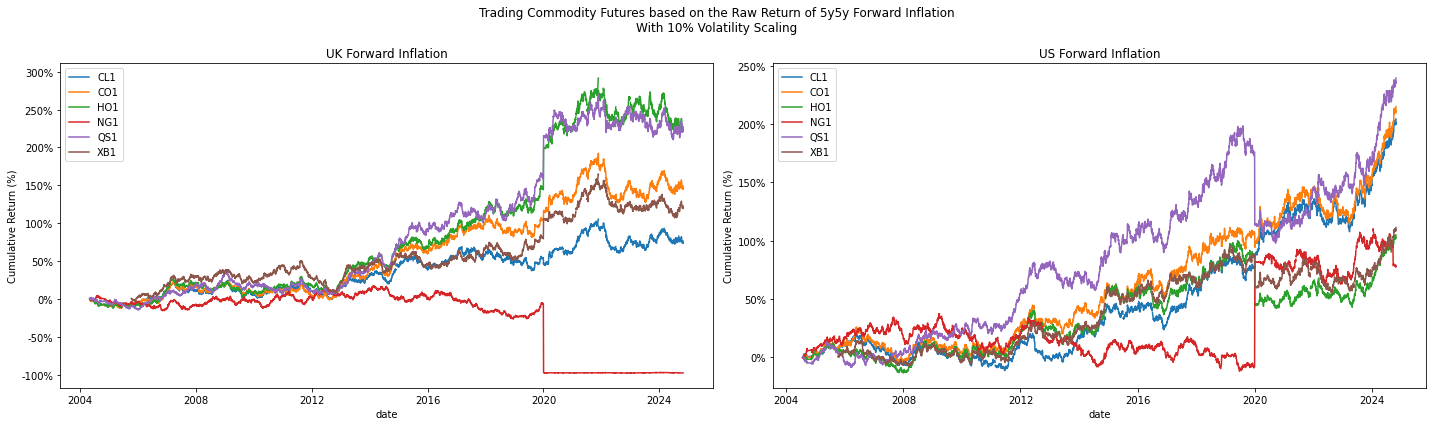

In [6]:
plot_rtn(df_raw, "Raw Return")

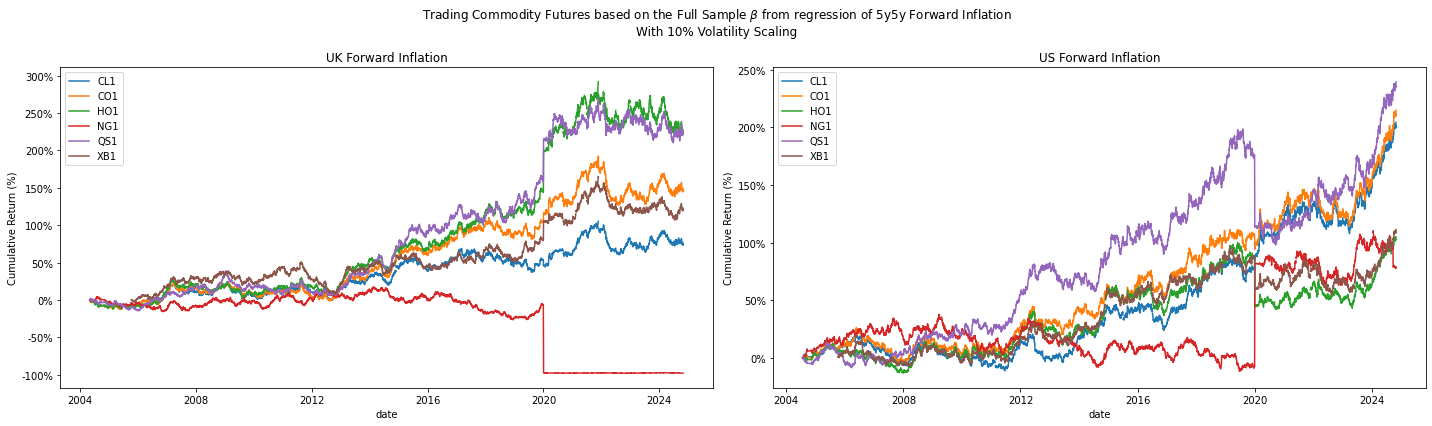

In [7]:
plot_rtn(df_is, r"Full Sample $\beta$ from regression")

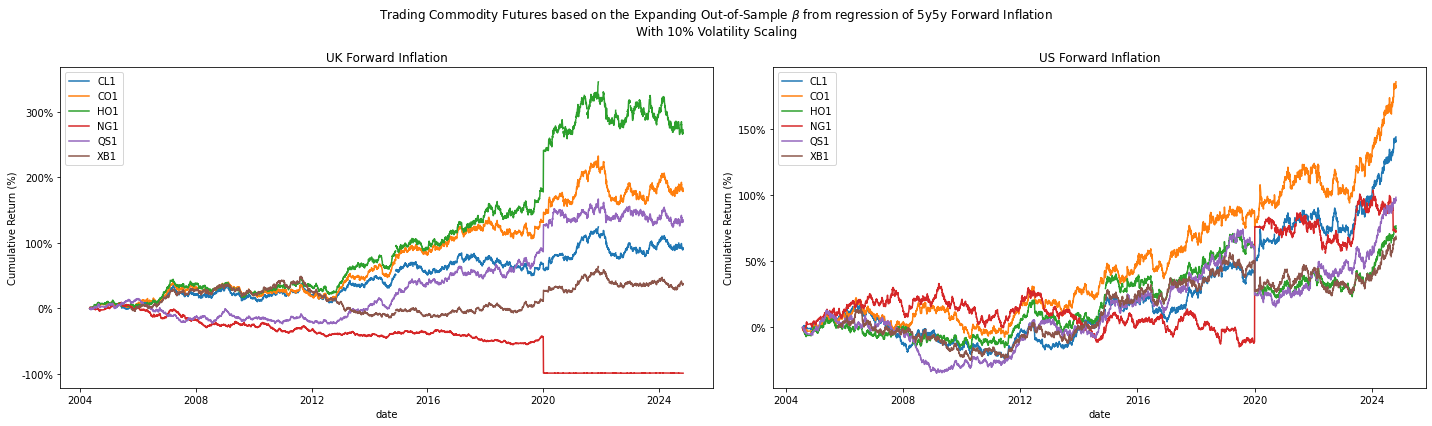

In [8]:
plot_rtn(df_oos, r"Expanding Out-of-Sample $\beta$ from regression")

In [9]:
def get_sharpe(df_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_rtn.drop(
        columns = ["date"]).
        groupby(["group", "inf_ticker", "security"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sharpe = get_sharpe(df_rtn)

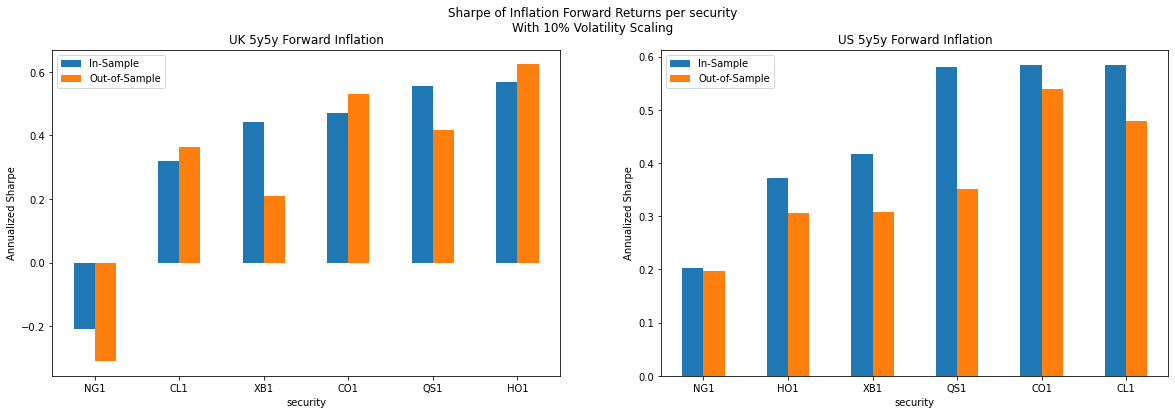

In [10]:
def plot_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 
    
    inflation_tickers = df_sharpe.inf_ticker.drop_duplicates().sort_values().to_list()
    fig, axes         = plt.subplots(ncols = len(inflation_tickers), figsize = (20,6))

    col_renamer = {
        "in_sample" : "In-Sample",
        "out_sample": "Out-of-Sample"}

    title_renamer = {
        "FWISBP55": "UK 5y5y Forward Inflation",
        "FWISUS55": "US 5y5y Forward Inflation"}

    for inflation_ticker, ax in zip(inflation_tickers, axes.flatten()):

        (df_sharpe.query(
            "inf_ticker == @inflation_ticker").
            rename(columns = {"group": ""}).
            pivot(index = "security", columns = "", values = "sharpe").
            sort_values("in_sample").
            rename(columns = col_renamer).
            plot(
                ax     = ax,
                kind   = "bar",
                title  = title_renamer[inflation_ticker],
                rot    = 0,
                ylabel = "Annualized Sharpe"))
        
    fig.suptitle("Sharpe of Inflation Forward Returns per security\nWith 10% Volatility Scaling")
    
plot_sharpe(df_sharpe)

## Portfolio Optimization

In [11]:
def get_port(df_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_port = (df_rtn.drop(
        columns = ["security"]).
        groupby(["date", "inf_ticker", "group"]).
        agg("mean").
        reset_index())
    
    return df_port

df_port = get_port(df_rtn)

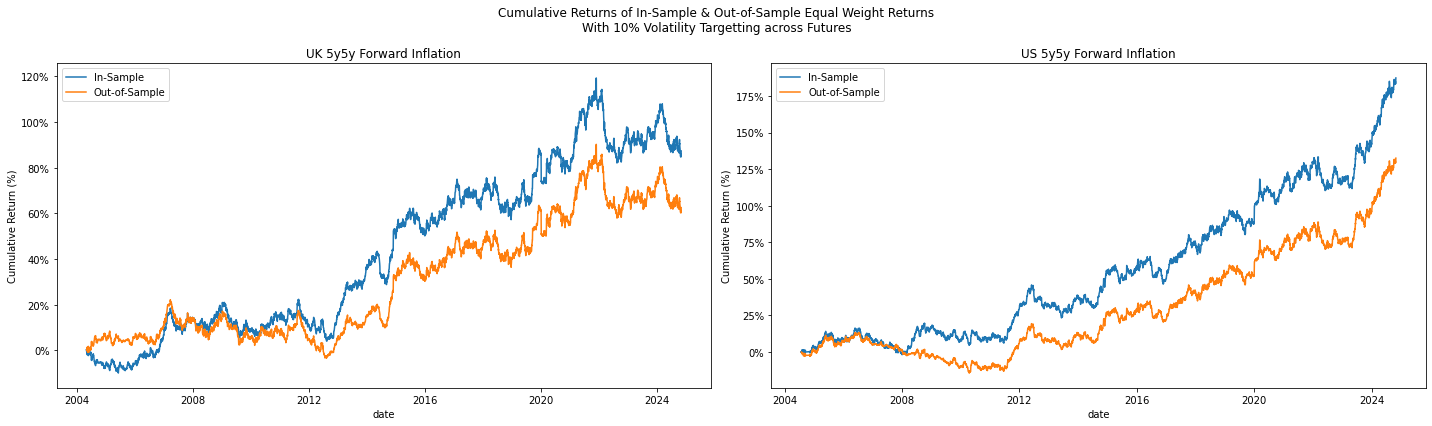

In [12]:
def plot_port_rtn(df_port: pd.DataFrame) -> plt.Figure: 
    
    tickers   = df_port.inf_ticker.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(tickers), figsize = (20,6))

    title_renamer = {
        "FWISBP55": "UK 5y5y Forward Inflation",
        "FWISUS55": "US 5y5y Forward Inflation"}

    for ticker, ax in zip(tickers, axes.flatten()):

        (df_port.query(
            "inf_ticker == @ticker").
            rename(columns = {"group": ""}).
            pivot(index = "date", columns = "", values = "signal_rtn").
            rename(columns = {
                "in_sample" : "In-Sample",
                "out_sample": "Out-of-Sample"}).
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = title_renamer[ticker],
                ylabel = "Cumulative Return (%)"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    fig.suptitle("Cumulative Returns of In-Sample & Out-of-Sample Equal Weight Returns\nWith 10% Volatility Targetting across Futures")
    plt.tight_layout()
    
plot_port_rtn(df_port)

# 2012 Policy Revision & Target Inflation

In [13]:
def get_port_sharpe(df_port: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df_port.drop(
        columns = ["date"]).
        groupby(["inf_ticker", "group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(
            before = "Full Sample",
            sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    df_sep = (df_port.assign(
        year = lambda x: pd.to_datetime(x.date).dt.year,
        before = lambda x: np.where(x.year < 2012, "Before 2012", "After 2012"))
        [["inf_ticker", "group", "signal_rtn", "before"]].
        groupby(["inf_ticker", "group", "before"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    df_out = pd.concat([df_tmp, df_sep])
    return df_out

df_port_sharpe = get_port_sharpe(df_port)

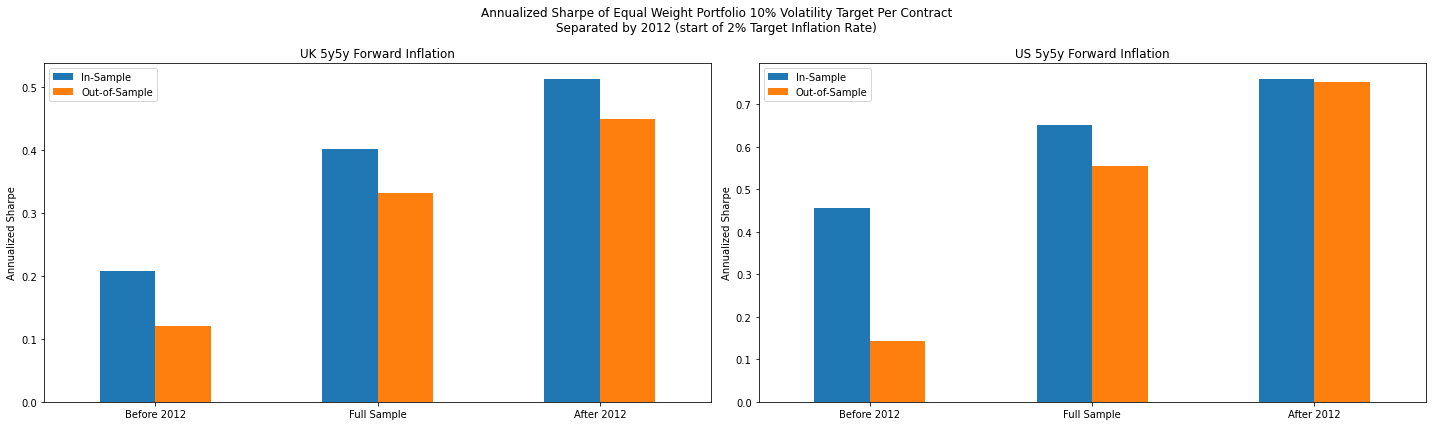

In [14]:
def plot_port_sharpe(df_port_sharpe: pd.DataFrame) -> plt.Figure:     
    
    inflation_tickers = df_port_sharpe.inf_ticker.drop_duplicates().sort_values().to_list()
    fig, axes         = plt.subplots(ncols = len(inflation_tickers), figsize = (20,6))

    title_renamer = {
        "FWISBP55": "UK 5y5y Forward Inflation",
        "FWISUS55": "US 5y5y Forward Inflation"}

    for inflation_ticker, ax in zip(inflation_tickers, axes.flatten()):

        (df_port_sharpe.query(
            "inf_ticker == @inflation_ticker").
            rename(columns = {"group": ""}).
            pivot(index = "before", columns = "", values = "sharpe").
            sort_values("in_sample").
            rename(columns = {
                "in_sample" : "In-Sample",
                "out_sample": "Out-of-Sample"}).
            plot(
                title  = title_renamer[inflation_ticker],
                ax     = ax, 
                kind   = "bar",
                rot    = 0,
                ylabel = "Annualized Sharpe",
                xlabel = ""))

    fig.suptitle("Annualized Sharpe of Equal Weight Portfolio 10% Volatility Target Per Contract\nSeparated by 2012 (start of 2% Target Inflation Rate)")
    plt.tight_layout()
    
plot_port_sharpe(df_port_sharpe)

In [15]:
def get_sec_sharpe(df_rtn: pd.DataFrame) -> pd.DataFrame: 
    
    df_sharpe = (df_rtn.assign(
        year = lambda x: pd.to_datetime(x.date).dt.year,
        year_group = lambda x: np.where(x.year < 2012, "Before 2012", "After 2012"))
        [["security", "inf_ticker", "group", "year_group", "signal_rtn"]].
        groupby(["security", "inf_ticker", "group", "year_group"]).
        agg(["mean", "std"])
        ["signal_rtn"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())
    
    return df_sharpe

df_sec_sharpe = get_sec_sharpe(df_rtn)

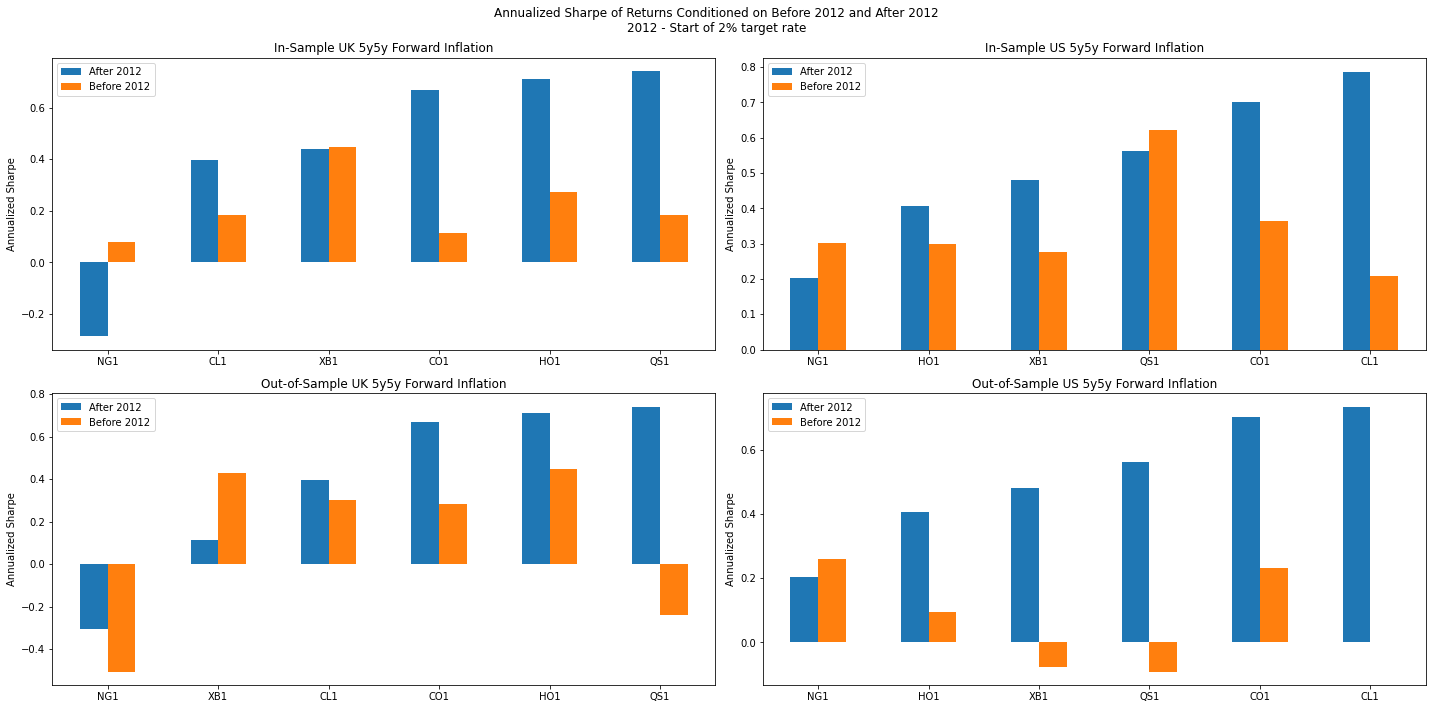

In [16]:
def plot_sec_sharpe(df_sec_sharpe: pd.DataFrame) -> plt.Figure: 
    
    df_tmp = (df_sec_sharpe.assign(
        inf_ticker = lambda x: np.where(x.inf_ticker == "FWISBP55", "UK 5y5y Forward Inflation", "US 5y5y Forward Inflation"),
        group      = lambda x: np.where(x.group == "in_sample", "In-Sample", "Out-of-Sample"),
        group_var  = lambda x: x.group + " " + x.inf_ticker))

    group_vars = df_tmp.group_var.drop_duplicates().sort_values().to_list()
    fig, axes  = plt.subplots(ncols = len(group_vars) // 2, nrows = len(group_vars) // 2, figsize = (20,10))

    for group, ax in zip(group_vars, axes.flatten()):

        (df_tmp.query(
            "group_var == @group").
            rename(columns = {"year_group": ""}).
            pivot(index = "security", columns = "", values = "sharpe").
            sort_values("After 2012").
            plot(
                kind   = "bar",
                ax     = ax,
                rot    = 0,
                ylabel = "Annualized Sharpe",
                title  = group,
                xlabel = ""))

    fig.suptitle("Annualized Sharpe of Returns Conditioned on Before 2012 and After 2012\n2012 - Start of 2% target rate")
    plt.tight_layout()
    
plot_sec_sharpe(df_sec_sharpe)